In [1]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def make_2D(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        key_list = []
        for e in series[key]:
            key_list.append([e]) # try brackets here
        l.append(key_list)
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 3.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 2.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 1.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 0.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

torch.Size([93, 32, 7, 1])
torch.Size([93, 5])
torch.Size([371, 32, 7, 1])
torch.Size([371, 5])


[[-0.04510970625758805], [0.15548292136690203], [0.18864269610476436], [0.03013477080729921], [0.02615070618718543], [-0.06870381184544468], [-0.016733536172175174]]
[[1.43357148915248], [1.3875110596464684], [1.3820930323177478], [1.3323338797004969], [1.380012570094935], [1.447214125314459], [1.3975924169719627]]
[[0.16028511925576938], [0.10539241581115354], [0.030515113454916788], [0.020483510064475144], [0.08704708302286145], [-0.04178909919001301], [-0.13672306340039284]]
[[1.410143913334849], [1.3413245131443865], [1.269566923118981], [1.2557151894274403], [1.3029415789401941], [1.3598634687573259], [1.3526648491919826]]
[[-0.17057047096524947], [0.1742577696131439], [0.2600980846614596], [-0.0445378944616656], [-0.1808554290899783], [-0.25808558722859654], [-0.0003875307702551616]]
[[0.9147009694039112], [0.8802537460011054], [0.8675173571074436], [0.8882761794014501], [1.022760088

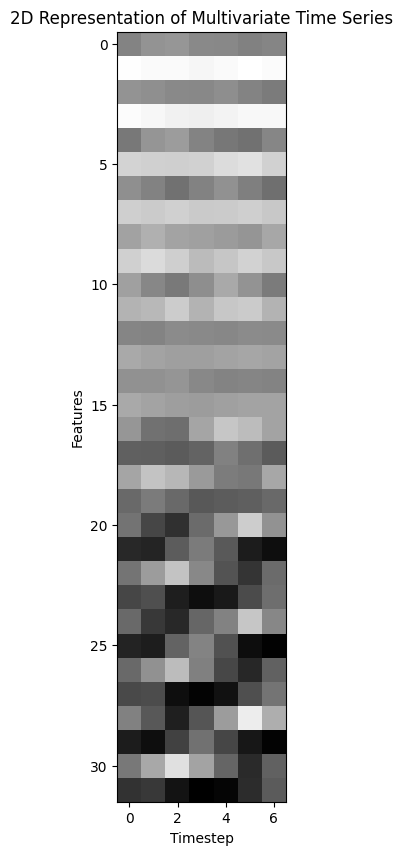

In [3]:
# loading data

X_train_list = []
y_train_list = []

X_test_list = []
y_test_list = []

with open("..\\test_examples.txt") as t:
    test_examples = t.readlines()

for example in test_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = make_2D(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_test_list.append(x_example)
    y_test_list.append(y_example)

X_test = torch.tensor(X_test_list)
y_test = torch.tensor(y_test_list)
print(X_test.size())
print(y_test.size())

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

for example in training_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = make_2D(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_train_list.append(x_example)
    y_train_list.append(y_example)

X_train = torch.tensor(X_train_list)
y_train = torch.tensor(y_train_list)
print(X_train.size())
print(y_train.size())

print('\n')

for x in X_train_list[0]:
    print(x)

print('\n')

fig = plt.figure(figsize=(10, 10))
plt.set_cmap('gray')
plt.imshow(X_train_list[0])
plt.xlabel('Timestep')
plt.ylabel('Features')
plt.title('2D Representation of Multivariate Time Series')

# N H W C  TO  N C H W

X_train = X_train.permute(0, 1, 3, 2)
X_test = X_test.permute(0, 1, 3, 2)

In [11]:
# setting up CNN

conv_1 = 32
conv_2 = 64
conv_3 = 128
conv_4 = 256

fc_size1 = 256
fc_size2 = 512
fc_size3 = 256
fc_size4 = 128
fc_size5 = 64
output_size = 5
batch_size = 371
learning_rate = 0.001

def flatten_conv(x):
    ret = []
    x = x.tolist()

    for example in x:
        ex=[]
        for i in range(len(example)):
            ex.append(example[i][0][0])
        ret.append(ex)
        # print(ex)
    return torch.tensor(ret)
    

class ConvNet(nn.Module):

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def __init__(self):
        super(ConvNet, self).__init__()
        self.apply(self._init_weights)
        # conv layers
        self.conv1 = nn.Conv2d(conv_1, conv_2, (1,3), stride=1)
        self.conv2 = nn.Conv2d(conv_2, conv_3, (1,3), stride=1)
        self.conv3 = nn.Conv2d(conv_3, conv_4, (1,3), stride=1)
        # fc layers
        self.fc1 = nn.Linear(fc_size1, fc_size2)
        self.fc2 = nn.Linear(fc_size2, fc_size3)
        self.fc3 = nn.Linear(fc_size3, fc_size4)
        self.fc4 = nn.Linear(fc_size4, fc_size5)
        self.fc5 = nn.Linear(fc_size5, output_size)
        # avg pooling
        self.pool = nn.AvgPool2d((1,3), stride=1)
        # sigmoid
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # fc layers
        x = flatten_conv(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        x = self.sigmoid(x)
        return x

model = ConvNet()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

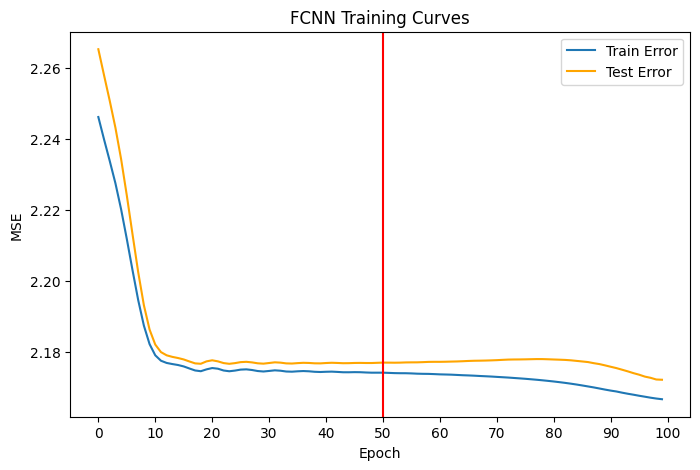

In [12]:
# model training

model.apply(model._init_weights)

num_epochs = 100

losses = []
test_losses = []
for epoch in range(num_epochs):
    # model.train()
    pred_y = model(X_train)
    loss = loss_function(pred_y, y_train)
    losses.append(loss.item())

    test_y = model(X_test)
    test_loss = loss_function(test_y, y_test)
    test_losses.append(test_loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

min_loss = min(test_losses)

fig, ax = plt.subplots(1, figsize=(8, 5))

ax.plot(losses, label="Train Error")
ax.plot(test_losses, label="Test Error", c="orange")
ax.set_title("FCNN Training Curves")
ax.set_xticks(np.linspace(0, num_epochs, num=11))

ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")

ax.legend()
ax.axvline(50, c='r', label='Training Termination')